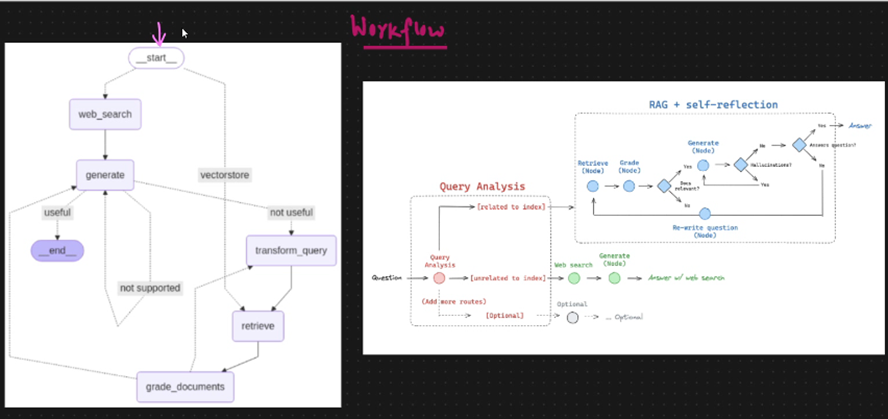

In [ ]:
#✅ 1. Environment Setup
import os
from dotenv import load_dotenv

# Load keys from .env file
load_dotenv()

# Set environment variables
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TABELLAE_API_KEY")
#🧠 2. Build the Vectorstore
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

# Define source URLs
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load and flatten documents
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split into chunks
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Create vectorstore
vectorstore = FAISS.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()
#🧭 3. Query Classifier (Router)
from typing import Literal
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# Output schema
class RouteQuery(BaseModel):
    datasource: Literal["vectorstore", "web_search"] = Field(...)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

route_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}")
])

question_router = route_prompt | structured_llm_router
#🔍 4. Retrieval Grader
class GradeDocuments(BaseModel):
    binary_score: str = Field(description="'yes' if relevant, otherwise 'no'")

structured_llm_grader = llm.with_structured_output(GradeDocuments)

grade_prompt = ChatPromptTemplate.from_messages([
    ("system", "Grade document relevance to question. Return 'yes' or 'no'."),
    ("human", "Document:\n\n{document}\n\nQuestion:\n\n{question}")
])

retrieval_grader = grade_prompt | structured_llm_grader
#✍️ 5. RAG Answer Generator
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")
rag_chain = prompt | llm | StrOutputParser()
#🤖 6. Hallucination Grader
class GradeHallucinations(BaseModel):
    binary_score: str = Field(description="'yes' if grounded in facts")

hallucination_prompt = ChatPromptTemplate.from_messages([
    ("system", "Check if the answer is based on retrieved facts. Return 'yes' or 'no'."),
    ("human", "Facts:\n\n{documents}\n\nAnswer:\n\n{generation}")
])

hallucination_grader = hallucination_prompt | llm.with_structured_output(GradeHallucinations)
#✅ 7. Answer Quality Grader
class GradeAnswer(BaseModel):
    binary_score: str = Field(description="'yes' if the answer resolves the question")

answer_prompt = ChatPromptTemplate.from_messages([
    ("system", "Check if the answer addresses the question. Return 'yes' or 'no'."),
    ("human", "Question:\n\n{question}\n\nAnswer:\n\n{generation}")
])

answer_grader = answer_prompt | llm.with_structured_output(GradeAnswer)
#🔁 8. Question Rewriter
from langchain_core.output_parsers import StrOutputParser

re_write_prompt = ChatPromptTemplate.from_messages([
    ("system", "Rewrite the question to improve retrieval."),
    ("human", "Original Question:\n\n{question}")
])

question_rewriter = re_write_prompt | llm | StrOutputParser()
#🌐 9. Web Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.schema import Document

web_search_tool = TavilySearchResults(k=3)
#🧩 10. LangGraph State + Functions
#Define Graph State
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    question: str
    generation: str
    documents: List[Document]
#Node Functions
def retrieve(state):
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def grade_documents(state):
    question = state["question"]
    filtered_docs = []
    for d in state["documents"]:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        if score.binary_score == "yes":
            filtered_docs.append(d)
    return {"documents": filtered_docs, "question": question}

def generate(state):
    generation = rag_chain.invoke({"context": state["documents"], "question": state["question"]})
    return {**state, "generation": generation}

def transform_query(state):
    better_question = question_rewriter.invoke({"question": state["question"]})
    return {"documents": state["documents"], "question": better_question}

def web_search(state):
    docs = web_search_tool.invoke({"query": state["question"]})
    content = "\n".join([d["content"] for d in docs])
    return {"documents": [Document(page_content=content)], "question": state["question"]}
#🔀 Routing + Decision Functions
def route_question(state):
    route = question_router.invoke({"question": state["question"]})
    return "web_search" if route.datasource == "web_search" else "retrieve"

def decide_to_generate(state):
    return "transform_query" if not state["documents"] else "generate"

def grade_generation_v_documents_and_question(state):
    score = hallucination_grader.invoke({
        "documents": state["documents"],
        "generation": state["generation"]
    })

    if score.binary_score == "yes":
        answer_score = answer_grader.invoke({
            "question": state["question"],
            "generation": state["generation"]
        })
        return "useful" if answer_score.binary_score == "yes" else "not useful"

    return "not supported"
#🧠 11. Build LangGraph Workflow
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(GraphState)

workflow.add_node("web_search", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

# Define graph flow
workflow.add_conditional_edges(START, route_question, {
    "web_search": "web_search",
    "vectorstore": "retrieve"
})

workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges("grade_documents", decide_to_generate, {
    "generate": "generate",
    "transform_query": "transform_query"
})

workflow.add_edge("transform_query", "retrieve")

workflow.add_conditional_edges("generate", grade_generation_v_documents_and_question, {
    "useful": END,
    "not useful": "transform_query",
    "not supported": "generate"
})

# Compile the graph
app = workflow.compile()
#✅ 12. Run the App
# General knowledge via web
app.invoke({"question": "Who won the Cricket World Cup 2023?"})

# In-domain knowledge from vectorstore
app.invoke({"question": "What are the types of agent memory?"})
